In [2]:
import requests
from io import StringIO
import truststore
truststore.inject_into_ssl()
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Datasets

In [69]:
def get_wine_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    data = pd.read_csv(url,sep=';')
    return data

In [251]:
def get_qwerty_dataset(nPerClust=100):
    blur = 1

    A = [1,1]
    B = [5,1]
    C = [3,-2]

    a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
    b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]
    c = [ C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur ]

    # true labels
    labels_np = np.vstack((
        np.zeros((nPerClust,1)),
        np.ones((nPerClust,1)),
        np.ones((nPerClust,1))*2
    ))

    data_np = np.hstack((a,b,c)).T
    data = torch.tensor(data_np).float()
    labels = torch.squeeze(torch.tensor(labels_np).long())
    return data, labels

# Metaparameters

## Mini-Batching Wine

In [224]:
data = get_wine_dataset()
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


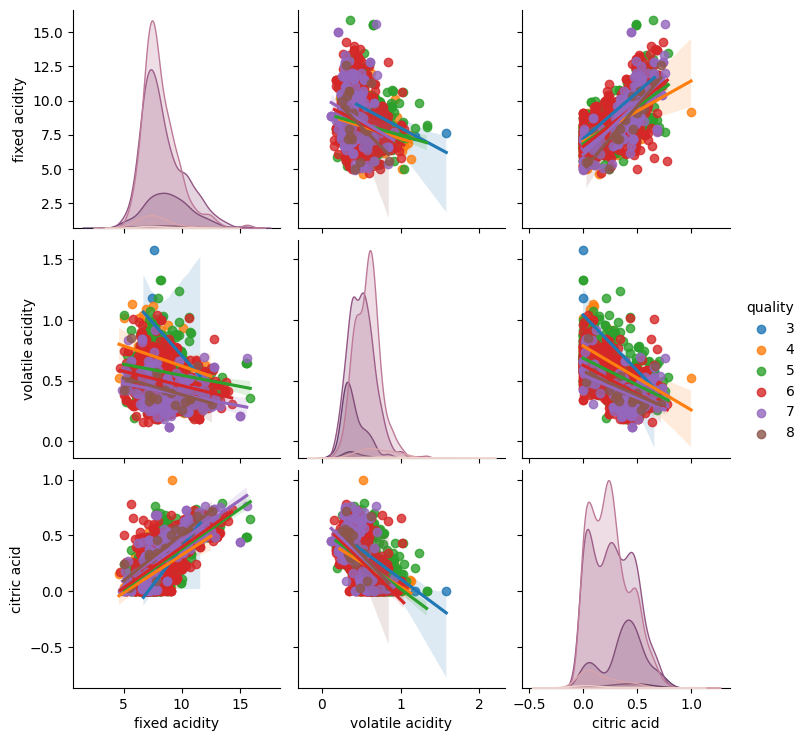

/var/folders/0z/cm5blxwn59lfh8sxl1dd9dgw0000gp/T/ipykernel_83910/2096482297.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


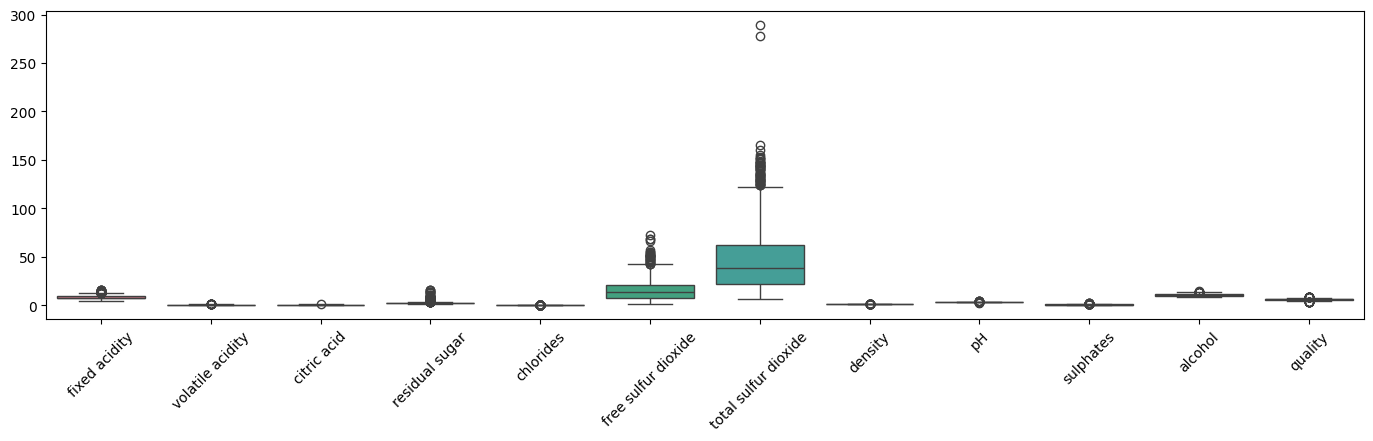

In [225]:
# pairwise plots
cols2plot = ['fixed acidity','volatile acidity','citric acid','quality']
sns.pairplot(data[cols2plot],kind='reg',hue='quality')
plt.show()

# plot some data
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [226]:
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')

for col in cols2zscore:
  meanval   = np.mean(data[col])
  stdev     = np.std(data[col],ddof=1)
  data[col] = (data[col]-meanval) / stdev

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data.loc[data['quality'] > 5, 'boolQuality'] = 1
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5,0
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,5,0
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,5,0
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,6,1
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217415,0.403103,-0.980362,-0.382151,0.053829,1.541571,-0.075020,-0.978459,0.899605,-0.461036,0.072271,5,0
1595,-1.389721,0.123866,-0.877693,-0.240300,-0.541090,2.210777,0.137777,-0.861893,1.353012,0.600867,0.729136,6,1
1596,-1.159980,-0.099523,-0.723690,-0.169374,-0.243630,1.254769,-0.196617,-0.533387,0.705287,0.541872,0.541460,6,1
1597,-1.389721,0.654416,-0.775024,-0.382151,-0.264878,1.541571,-0.075020,-0.676446,1.676875,0.305894,-0.209243,5,0


In [227]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
print("Before: ", labels.shape)
# need to transform labels into 2x1 tensor
labels = labels[:, None]
print("After: ", labels.shape)


Before:  torch.Size([1599])
After:  torch.Size([1599, 1])


In [228]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

def get_test_loader():
    return DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

def get_train_loader(size):
    return DataLoader(train_data,batch_size=size,shuffle=True,drop_last=True)

def create_model():
    model = nn.Sequential(
        nn.Linear(11, 16),
        nn.ReLU(),         # activation unit
        nn.Linear(16,32),  # hidden layer
        nn.ReLU(),         # activation unit
        nn.Linear(32,1),   # output units
    )
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model,loss_func,optimizer

def train_model(model, loss_func, optimizer, train_loader, test_loader):
    numepochs = 500
    # initialize accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = model(X)
            loss = loss_func(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
            batchLoss.append( loss.item() )

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():
            yHat = model(X)
        testAcc.append( 100*torch.mean(((yHat > 0) == y).float()).item() )

    # function output
    return trainAcc,testAcc,losses 


In [229]:
train_acc_list = []
test_acc_list = []

for i in range(6):
    batch_size = 2**(i+1)
    model,lossfun,optimizer = create_model()
    trainAcc,testAcc,losses = train_model(
        model,
        lossfun,
        optimizer,
        get_train_loader(batch_size),
        get_test_loader())
    train_acc_list.append(trainAcc)
    test_acc_list.append(testAcc)

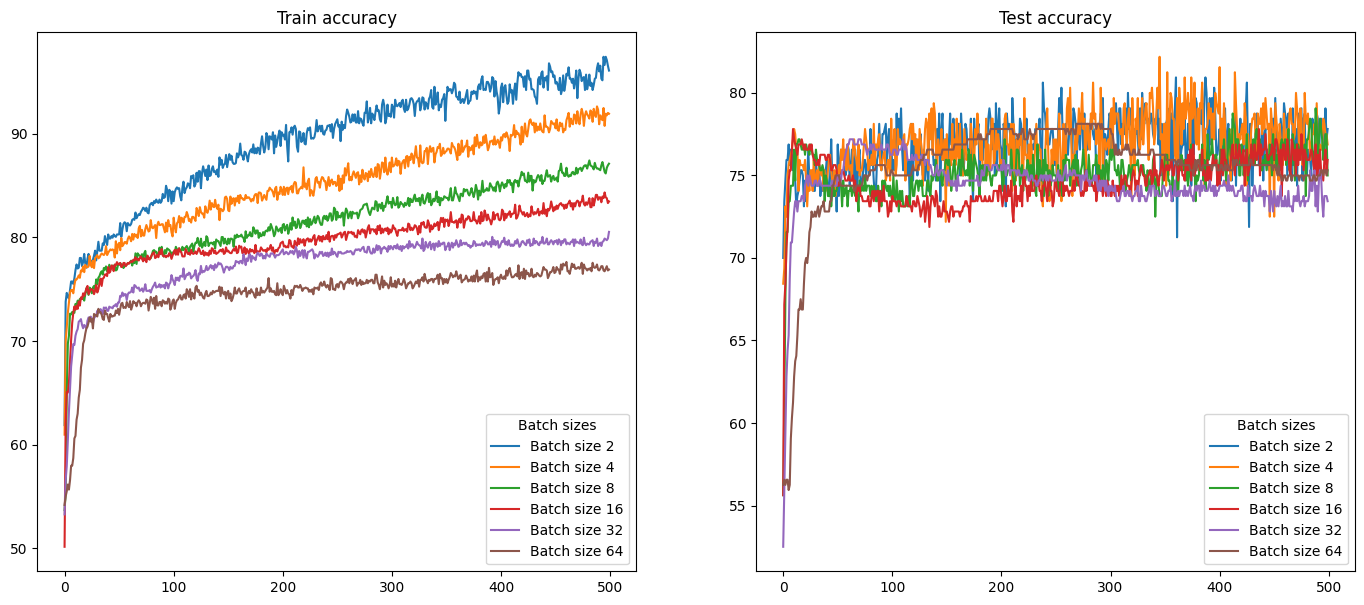

In [230]:
fig,ax = plt.subplots(1,2,figsize=(17,7))
ax[0].set_title('Train accuracy')
ax[1].set_title('Test accuracy')

legends = []
for i in range(6):
    batch_size = 2**(i+1)
    ax[0].plot(train_acc_list[i], label='Batch size %d'%batch_size)
    ax[1].plot(test_acc_list[i], label='Batch size %d'%batch_size)
ax[0].legend(title='Batch sizes')
ax[1].legend(title='Batch sizes')


## Batch Norm

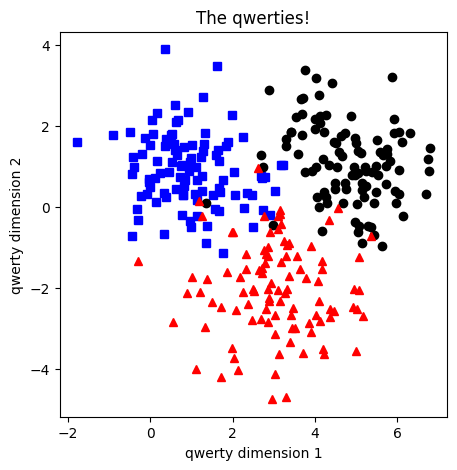

In [252]:
data, labels = get_qwerty_dataset()
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [232]:
class BatchedNormModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 16)
        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32,3)
    
    def forward(self, x, doBN):
        if doBN:
            x = F.relu(self.input(x))
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = F.relu(x)

            x = self.bnorm2(x)
            x = self.fc2(x)
            x = F.relu(x)
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
        return self.output(x)


In [233]:
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=0.1)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True, drop_last=True)

for X,y in train_loader:
    print(y)


tensor([2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2,
        2, 2, 1, 0, 1, 2, 0, 1])
tensor([1, 1, 0, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 2, 1, 2, 2, 2, 1, 0,
        2, 2, 1, 0, 1, 0, 1, 0])
tensor([1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0,
        0, 0, 0, 1, 2, 1, 0, 1])
tensor([2, 1, 2, 2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2,
        1, 1, 2, 1, 1, 2, 2, 2])
tensor([0, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 0, 2, 2, 0, 1,
        0, 1, 2, 0, 0, 0, 0, 1])
tensor([2, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1, 2,
        2, 0, 0, 1, 2, 2, 1, 0])
tensor([1, 2, 2, 2, 0, 1, 2, 0, 0, 0, 1, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 2, 1])
tensor([0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2,
        2, 1, 1, 0, 0, 2, 2, 2])


In [234]:
numepochs = 1000

def train_model(model,doBN=True):
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

    loss = []
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []

        for X,y in train_loader:
            # forward pass and loss
            yHat = model(X,doBN)
            loss = loss_func(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat,axis=1) == y.flatten()      # booleans (false/true)
            matchesNumeric = matches.float()              # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric)  # average and x100
    
            batchAcc.append(accuracyPct.float().item())
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses.append(np.mean(batchLoss))



        ### test accuracy
        model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = model(X,doBN)
            predictions = torch.argmax(yHat, axis=1)
            matches = (predictions == y.flatten())
            testAcc.append(100 * torch.mean(matches.float()).item())

    # function output
    return trainAcc,testAcc,losses


In [235]:
model = BatchedNormModel()
trainAcc,testAcc,losses = train_model(model)

Final accuracy: 93.3333%


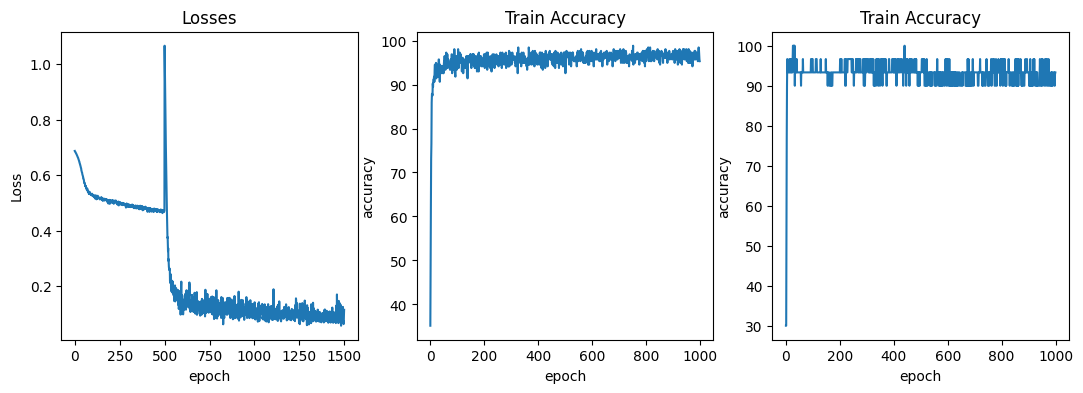

In [236]:
print('Final accuracy: %g%%' % testAcc[-1])

fig,ax = plt.subplots(1,3,figsize=(13,4))

ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Train Accuracy')

ax[2].plot(testAcc)
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].set_title('Train Accuracy')

plt.show()

## Compare RELU Variants

In [237]:
data = get_wine_dataset()
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data.loc[data['quality'] > 5, 'boolQuality'] = 1

data


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,5,0
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,6,1
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,6,1
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,5,0


In [238]:
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun

  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(nn,self.actfun)()

    x = actfun( self.input(x) )
    x = actfun( self.fc1(x) )
    x = actfun( self.fc2(x) )
    return self.output(x)

In [239]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # turn on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [240]:
# this cell takes ~2 mins

# list activation functions to test
activation_funs = [ 'ReLU', 'ReLU6', 'LeakyReLU']

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
  # create a model and train it
  winenet = ANNwine(actfun)
  trainByAct[:,ai],testByAct[:,ai],losses = trainTheModel()

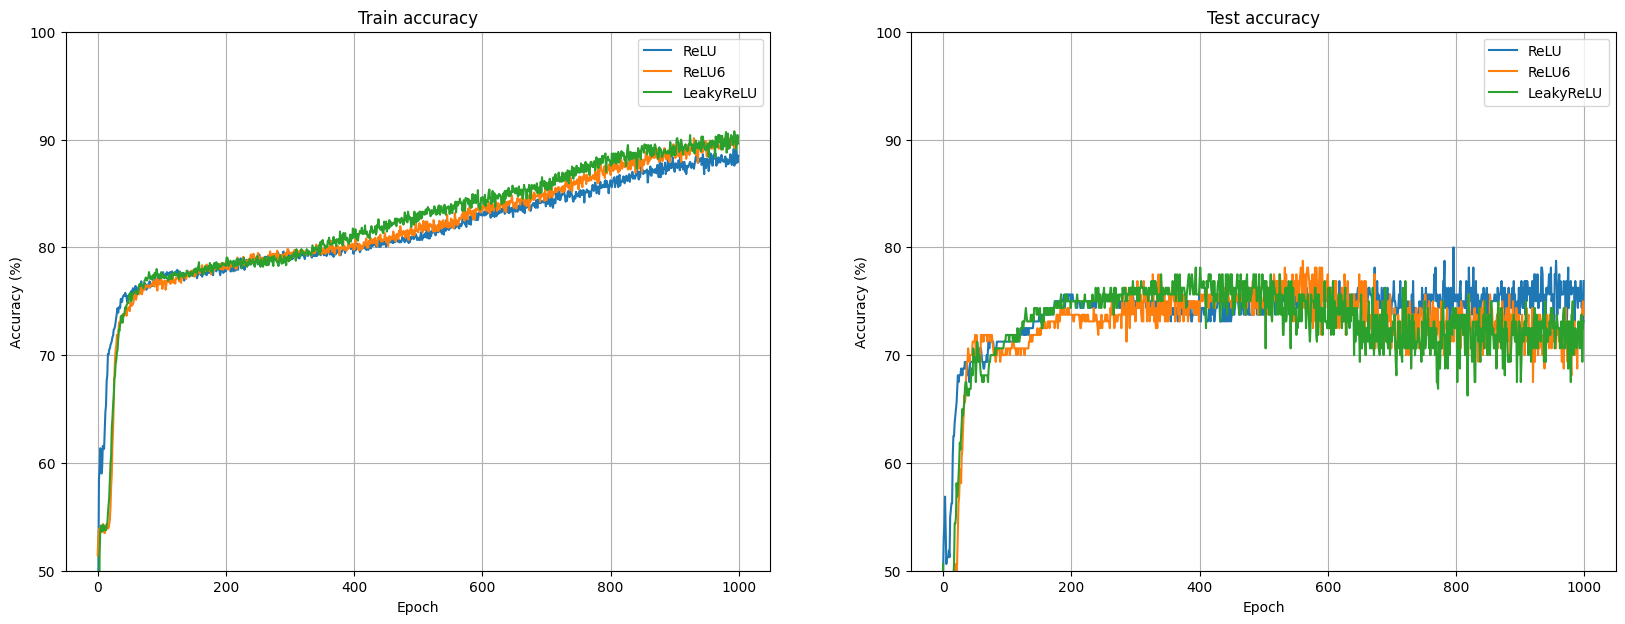

In [241]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

## Sugar

In [242]:
data = get_wine_dataset()
data = data[data['total sulfur dioxide']<200] # drop a few outliers
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [243]:
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('residual sugar')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['residual sugar'].values).float()
labels = labels[:,None]

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

In [244]:
input_vars = train_dataDataset.tensors[0].shape[1]


class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [245]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss  = []
  testLoss = [] 

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches

    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainLoss.append(np.mean(batchLoss))

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    
    testLoss.append(lossfun(yHat,y).item())

  # function output
  return trainLoss,testLoss

In [246]:
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,
                          batch_size=int(32), shuffle=True, drop_last=True)
winenet = ANNwine()
trainLoss,testLoss = trainTheModel()

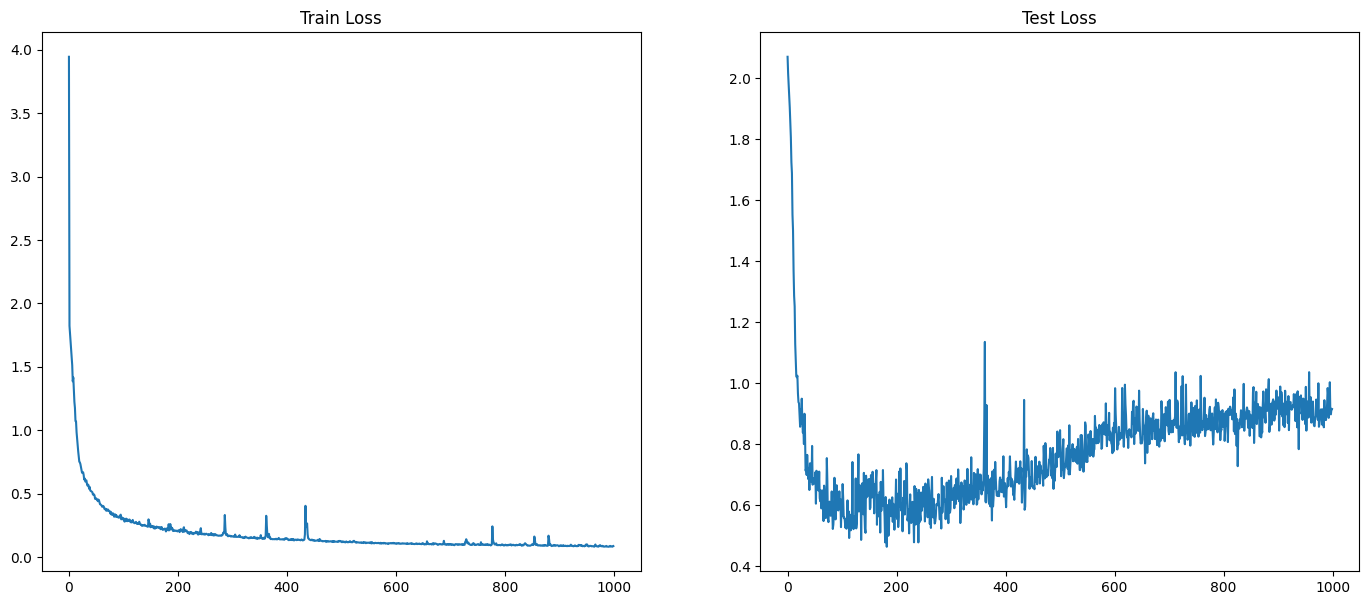

In [247]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(trainLoss)
ax[0].set_title('Train Loss')
ax[1].plot(testLoss)
ax[1].set_title('Test Loss')

plt.show()


## L2 Regularization

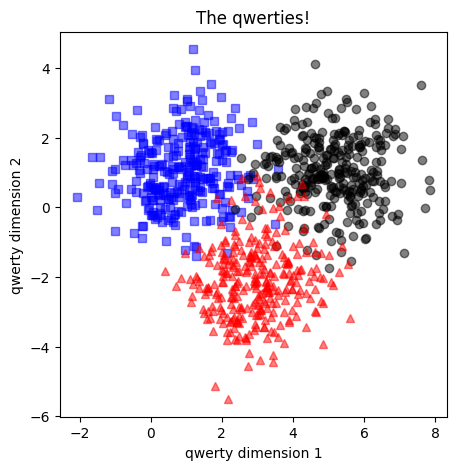

In [253]:
data,labels = get_qwerty_dataset(300)

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [255]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [256]:
def createTheQwertyNet(optimizerAlgo,l2lambda):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=0.001,weight_decay=l2lambda)

  return net,lossfun,optimizer

In [258]:
# a function that trains the model

def function2trainTheModel(optimizerType,l2lambda):

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType,l2lambda)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [270]:
l2lambdas = np.linspace(0, 0.1, 10)

trainAccs = []
testAccs = []

for _, l2lambda in enumerate(l2lambdas):
    trainAcc, testAcc, _, _ = function2trainTheModel('Adam', l2lambda)
    trainAccs.append(trainAcc)
    testAccs.append(testAcc)



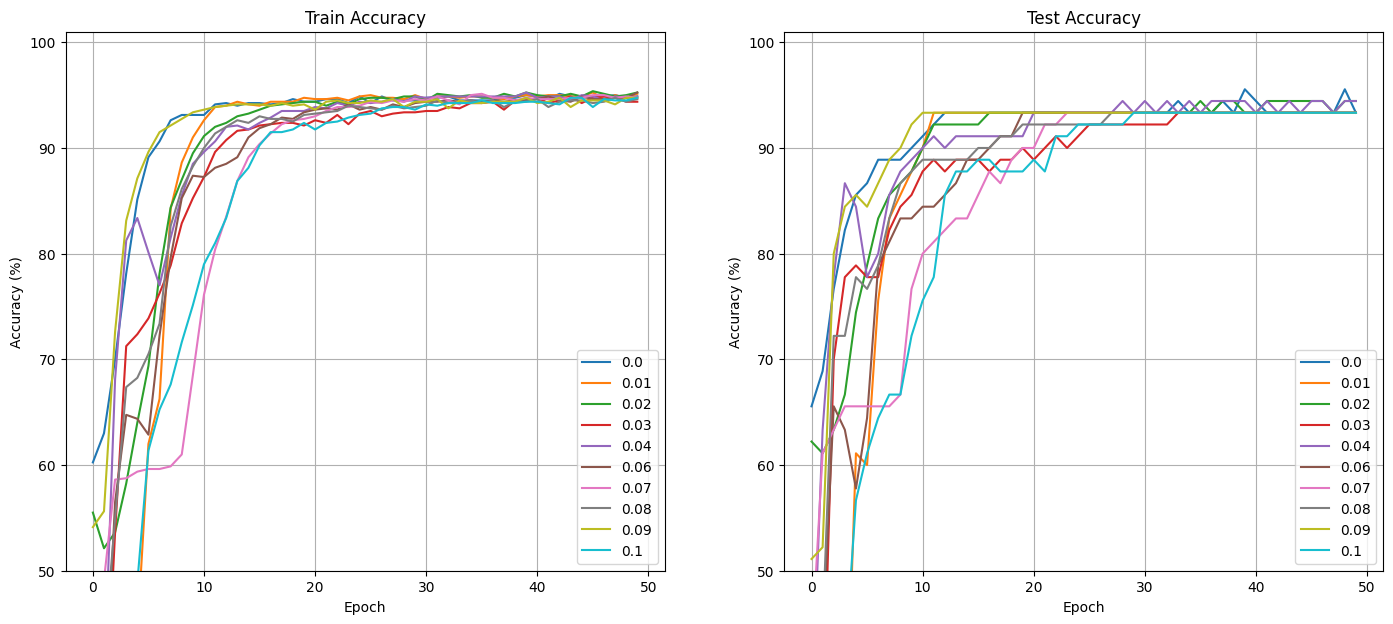

In [271]:
fig,ax = plt.subplots(1,2,figsize=(17,7))
for dset in trainAccs:
    ax[0].plot(dset)
ax[0].set_title('Train Accuracy')

for dset in testAccs:
    ax[1].plot(dset)
ax[1].set_title("Test Accuracy")


leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

# Feed Forward Network

## Binarize MNIST

Text(0.5, 1.0, 'Histogram of normalized data')

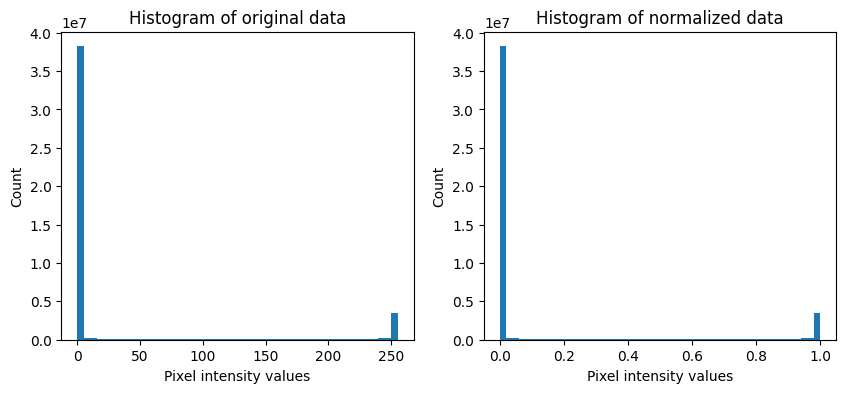

In [287]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../sample_data/mnist_train.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

Text(0.5, 1.0, 'Histogram of original data')

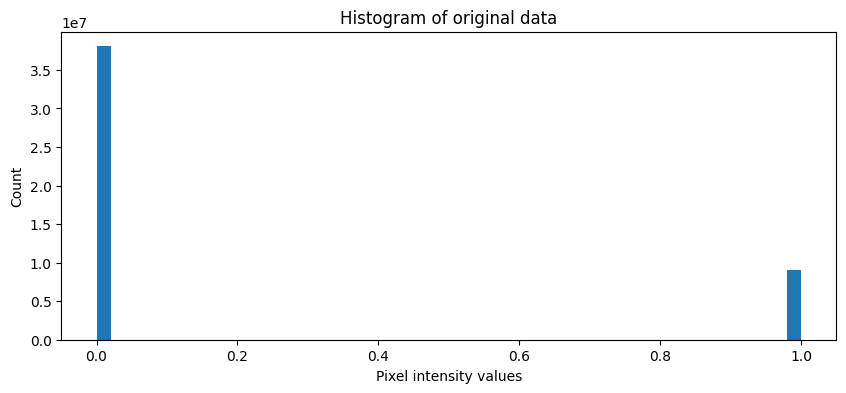

In [293]:
dataNorm[dataNorm > 0] = 1

fig,ax = plt.subplots(1,figsize=(10,4))
ax.hist(dataNorm.flatten(),50)
ax.set_xlabel('Pixel intensity values')
ax.set_ylabel('Count')
ax.set_title('Histogram of original data')

In [294]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [295]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [296]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3109, grad_fn=<NllLossBackward0>)


In [297]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


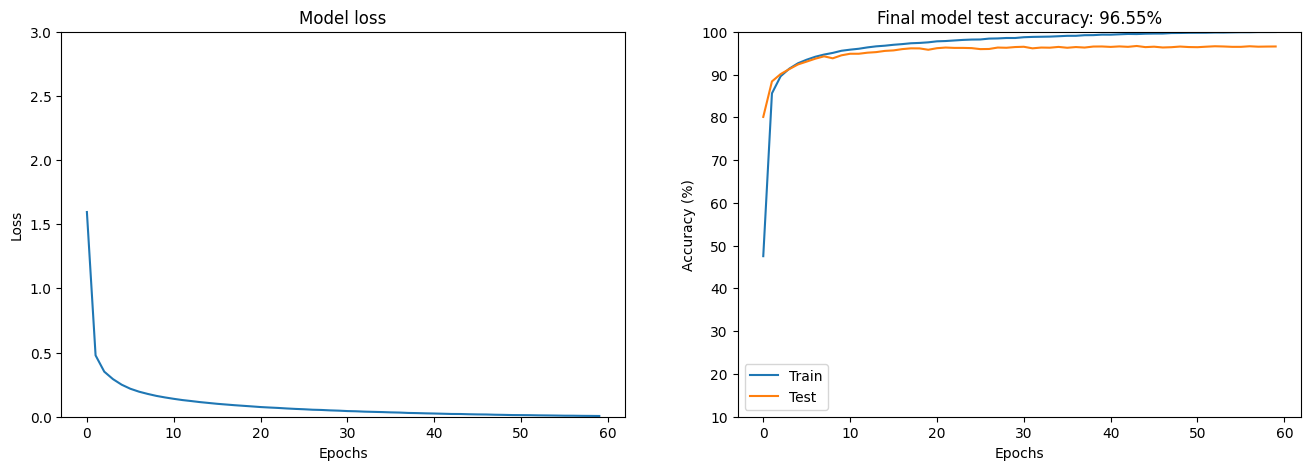

In [298]:
trainAcc,testAcc,losses,net = function2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

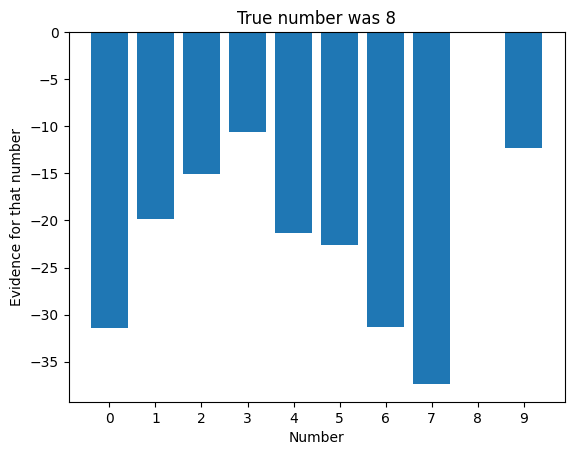

In [299]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  49   82  101  104  108  125  152  165  200  225  227  231  239  274
  276  323  353  361  364  399  402  413  481  502  505  576  609  615
  631  644  664  667  675  690  718  729  769  793  806  823  832  836
  955  964 1048 1056 1083 1093 1107 1115 1122 1153 1188 1195 1285 1312
 1322 1323 1378 1386 1415 1435 1508 1514 1596 1606 1630 1656 1671 1726
 1778 1812 1816 1818 1842 1886 1887 1942 1955 1998 2003 2049 2173 2190
 2217 2230 2260 2289 2298 2306 2376 2428 2446 2487 2503 2543 2593 2613
 2625 2627 2646 2666 2667 2705 2719 2728 2739 2802 2851 2871 2917 2930
 3012 3061 3062 3075 3112 3114 3117 3170 3218 3252 3305 3364 3370 3385
 3392 3402 3441 3471 3509 3534 3574 3598 3627 3659 3664 3815 3866 3908
 3920 3942 3944 3967 3993 3996 4029 4049 4064 4118 4161 4210 4226 4269
 4285 4372 4379 4464 4520 4575 4629 4631 4637 4656 4719 4831 4902 4921
 4959 4962 4982 4984 4986 4989 4991 5011 5031 5086 5114 5188 5211 5253
 5266 5299 5349 5363 5383 5384 5430 5505 5553 5570 5584 5585 5591 5599
 5602 

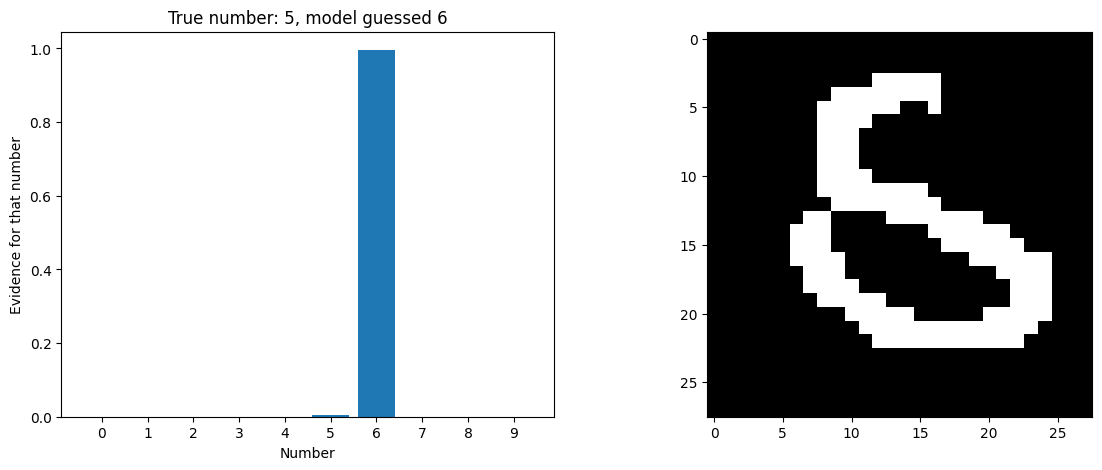

In [300]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

## Missing 7s

In [350]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../sample_data/mnist_train.csv','rb'),delimiter=',')

data = data[data[:,0] != 7,:]

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

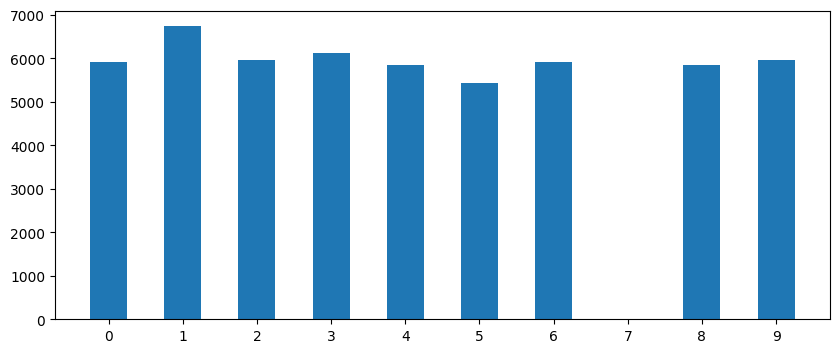

In [351]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
bins = np.arange(labels.min(), labels.max() + 2) - 0.5
ax.hist(labels, bins=bins, rwidth=0.5)
ax.set_xticks(np.arange(0,10))

In [352]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [353]:
dataNorm = data / np.max(data)
dataT = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()


In [354]:
net,lossfun,optimizer = createTheMNISTNet()
losses = []

for epochi in range(numepochs):
    # forward pass
    yHat = net(dataT)

    # compute loss
    loss = lossfun(yHat,labelsT)
    losses.append(loss)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [356]:
sdata = np.loadtxt(open('../sample_data/mnist_train.csv','rb'),delimiter=',')
sdata = sdata[sdata[:,0] == 7,:]
print(sdata)
sdata = sdata[:,1:]


[[7. 0. 0. ... 0. 0. 0.]
 [7. 0. 0. ... 0. 0. 0.]
 [7. 0. 0. ... 0. 0. 0.]
 ...
 [7. 0. 0. ... 0. 0. 0.]
 [7. 0. 0. ... 0. 0. 0.]
 [7. 0. 0. ... 0. 0. 0.]]


In [357]:
predictions = net(torch.Tensor(sdata)).detach()

In [358]:
predictions

tensor([[ 0.0000e+00, -4.0651e+02, -2.1932e+02,  ..., -5.2228e+02,
         -8.4680e+01, -1.3123e+02],
        [-4.3110e+01, -6.3815e+01, -1.1619e-02,  ..., -2.3874e+02,
         -7.7891e+01, -1.1758e+02],
        [-2.1565e+01, -2.3042e+02, -1.1181e-04,  ..., -3.6213e+02,
         -1.5805e+02, -1.3868e+02],
        ...,
        [ 0.0000e+00, -2.4263e+02, -1.1832e+02,  ..., -4.1119e+02,
         -2.2057e+01, -1.1783e+02],
        [ 0.0000e+00, -2.4380e+02, -1.2585e+02,  ..., -3.2300e+02,
         -2.6424e+01, -7.6894e+01],
        [ 0.0000e+00, -3.0623e+02, -1.3708e+02,  ..., -4.1458e+02,
         -9.0772e+01, -1.1365e+02]])

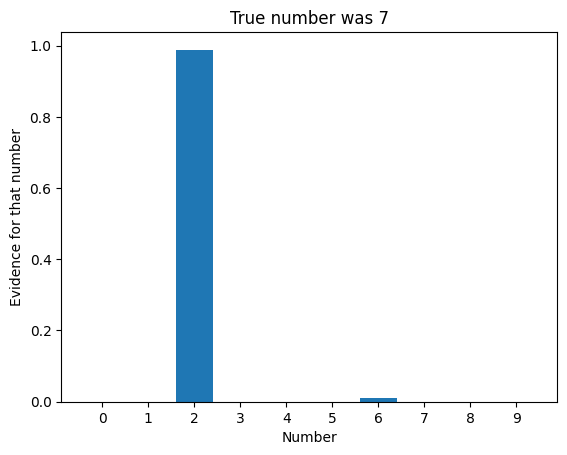

In [361]:
# Evidence for all numbers from one sample
sample2show = 1
plt_data = predictions[sample2show]

plt.bar(range(10),np.exp(plt_data)) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' % 7)
plt.show()

## Unbalanced Data

In [427]:
def get_dataset(split):
    data = get_wine_dataset()
    data = data[data['total sulfur dioxide']<200] # drop a few outliers

    # z-score all columns except for quality
    cols2zscore = data.keys()
    cols2zscore = cols2zscore.drop('quality')
    data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

    # create a new column for binarized (boolean) quality
    data['boolQuality'] = 0
    # data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
    data.loc[data['quality']>split,'boolQuality'] = 1

    dataT  = torch.tensor( data[cols2zscore].values ).float()
    labels = torch.tensor( data['boolQuality'].values ).float()
    labels = labels[:,None] # transform to matrix

    # use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = torch.utils.data.TensorDataset(train_data,train_labels)
    test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

    # finally, translate into dataloader objects
    batchsize    = 64
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader

In [394]:
class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun

  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

In [452]:
numepochs = 500

def trainTheModel(winenet, train_loader, test_loader):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []
  qualities = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [465]:
from sympy import per


test_splits = [4,5,6]

trainByAct = np.zeros((numepochs,len(test_splits)))
testByAct = np.zeros((numepochs,len(test_splits)))
lossesByAct = np.zeros((numepochs,len(test_splits)))
net = ANNwine('LeakyReLU')
perQualAccs = []

for idx,x in enumerate(test_splits):
    train, test = get_dataset(x)
    trainAct, testAct, losses = trainTheModel(net, train, test)
    trainByAct[:,idx] = trainAct
    testByAct[:,idx] = testAct
    lossesByAct[:,idx] = losses

    X,y = next(iter(test))
    itemAccuracy = ((net(X) > 0) == y).float()
    perQualAcc  = [ 100*torch.mean(itemAccuracy[y==0]) ,
                100*torch.mean(itemAccuracy[y==1]) ]
    perQualAccs.append(perQualAcc)
    

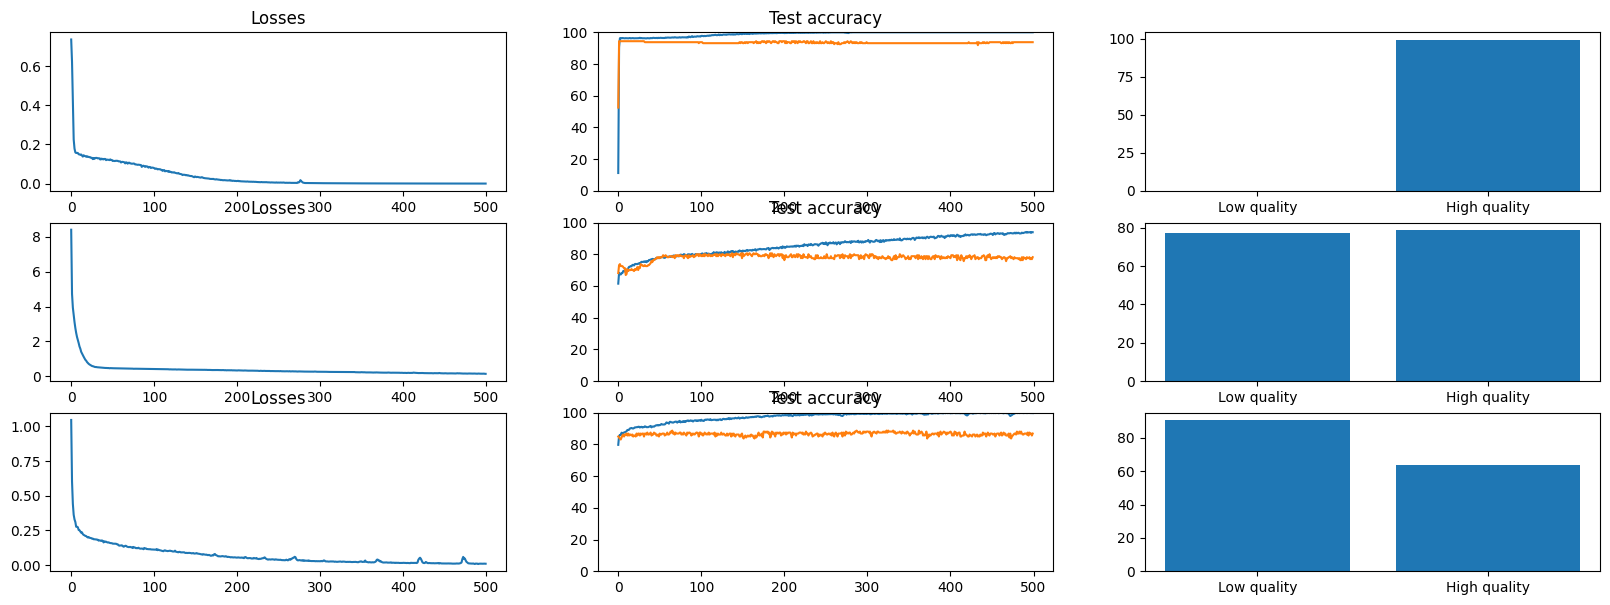

In [466]:
# plot some results
fig,ax = plt.subplots(3,3,figsize=(20,7))

for i in range(len(test_splits)):
    ax[i,0].plot(lossesByAct[:,i])
    ax[i,0].set_title('Losses')
    ax[i,1].plot(trainByAct[:,i])
    ax[i,1].plot(testByAct[:,i])
    ax[i,1].set_title('Test accuracy')
    ax[i,1].set_ybound(0,100)
    ax[i,2].bar(['Low quality','High quality'],perQualAccs[i])

plt.show()

## Adder Model

In [106]:
def create_dataset():
    input = np.zeros((400,2))
    out = np.array([])
    idx = 0
    for x in range(-10,10):
        for y in range(-10,10):
            input[idx,:] = [x, y] 
            out = np.append(out, x + y)
            idx += 1
    return torch.Tensor(input), torch.Tensor(out)


In [107]:
x,y = create_dataset()
y = y[:,None]
print(x.shape, y.shape)


torch.Size([400, 2]) torch.Size([400, 1])


In [108]:
train_data,test_data, train_labels,test_labels = train_test_split(x, y, test_size=0.1)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
batchsize = 32

train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [109]:
def createNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,16)

      ### hidden layer
      self.fc1 = nn.Linear(16,8)

      ### output layer
      self.output = nn.Linear(8,1)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [110]:
net,lossfun,optimizer = createNet()
x,y = next(iter(train_loader))
yhat = net(x)

loss = lossfun(yhat,y)

In [133]:
def trainTheModel(net, train_loader, test_loader):
  numepochs = 1000

  # initialize losses
  trainLoss  = []
  trainAcc = []
  testLoss = []
  testAcc = [] 

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches

    batchLoss = []
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      is_correct = (torch.round(yHat) == y)
      accuracy = 100 * torch.mean(is_correct.float())
      batchAcc.append(accuracy)
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainLoss.append(np.mean(batchLoss))
    trainAcc.append(np.mean(batchAcc))

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    
    testLoss.append(lossfun(yHat,y).item())
    is_correct = (torch.round(yHat) == y)
    accuracy = 100 * torch.mean(is_correct.float())
    testAcc.append(accuracy)

  # function output
  return trainLoss,testLoss,trainAcc,testAcc

In [134]:
net,lossfun,optimizer = createNet()
trainLoss,testLoss,trainAcc,testAcc = trainTheModel(net, train_loader, test_loader)

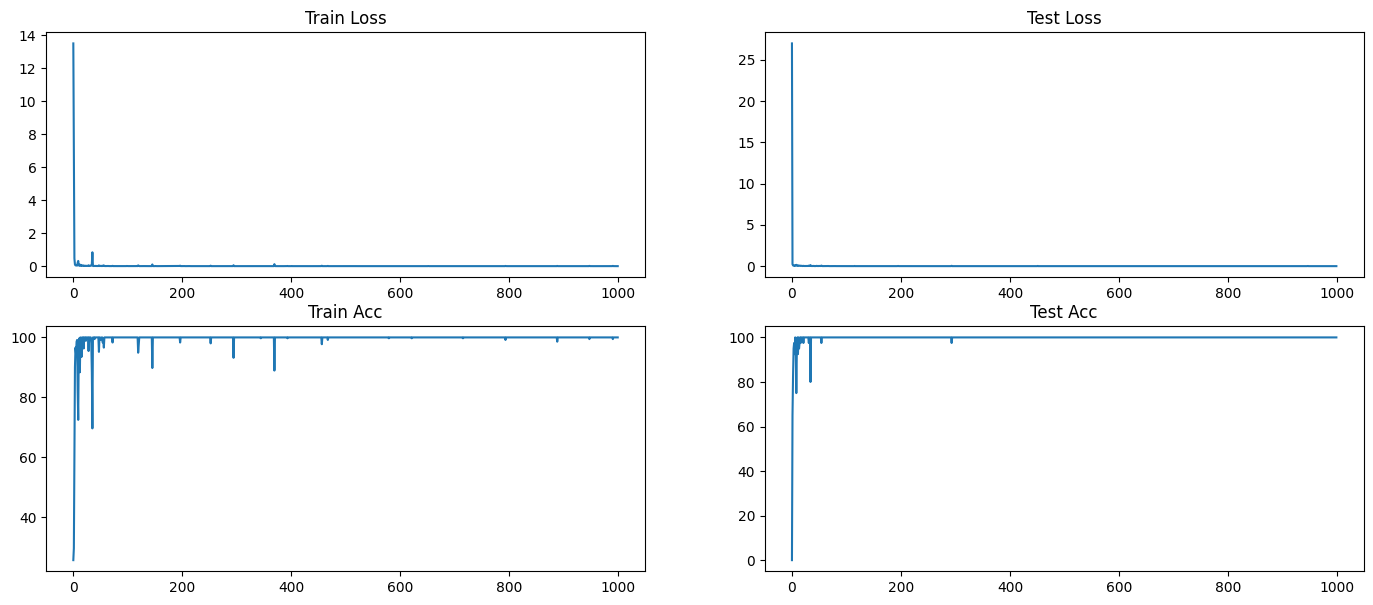

In [135]:
# plot some results
fig,ax = plt.subplots(2,2,figsize=(17,7))

ax[0,0].plot(trainLoss)
ax[0,0].set_title('Train Loss')
ax[0,1].plot(testLoss)
ax[0,1].set_title('Test Loss')

ax[1,0].plot(trainAcc)
ax[1,0].set_title('Train Acc')
ax[1,1].plot(testAcc)
ax[1,1].set_title('Test Acc')

plt.show()

In [136]:
net(torch.Tensor([[3.0, 5.0]]))

tensor([[7.9691]], grad_fn=<AddmmBackward0>)

In [137]:
from pickle import NONE


net = NONE
for i in range(10):
    net,lossfun,optimizer = createNet()
    trainLoss,testLoss,trainAcc,testAcc = trainTheModel(net, train_loader, test_loader)
    print('Model instance %s, Train Accuracy %f, Test Accuracy %f' % 
          (i, trainAcc[-1], testAcc[-1]))

Model instance 0, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 1, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 2, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 3, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 4, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 5, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 6, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 7, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 8, Train Accuracy 100.000000, Test Accuracy 100.000000
Model instance 9, Train Accuracy 100.000000, Test Accuracy 100.000000


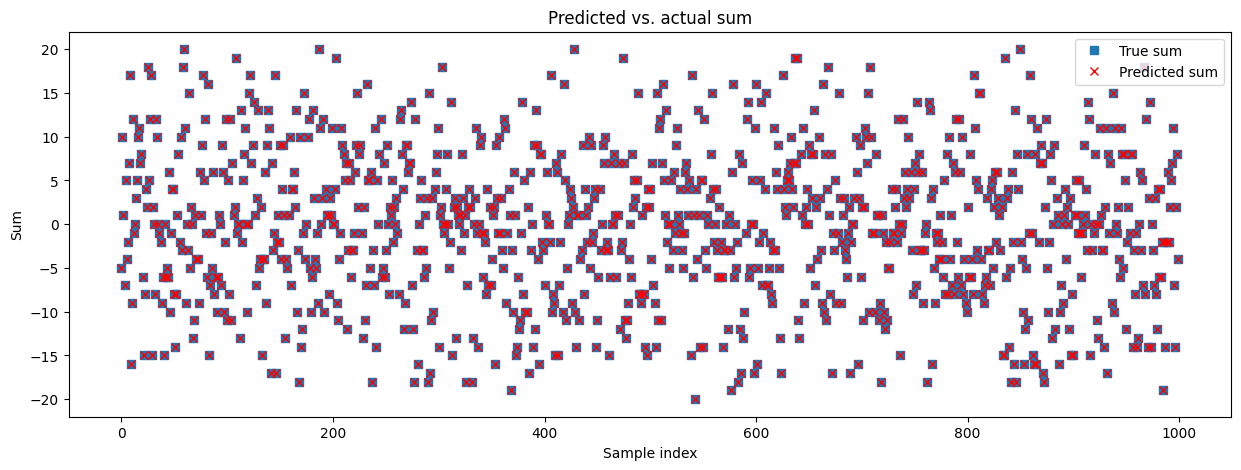

In [139]:
data = torch.randint(low=-10,high=11,size=(1000,2)).float()
labels = torch.sum(data,axis=1,keepdim=True)

with torch.no_grad():
    predictions = net(data)

fig = plt.figure(figsize=(15,5))
plt.plot(labels,'s')
plt.plot(np.round(predictions.detach()),'rx')
plt.legend(['True sum','Predicted sum'])
plt.xlabel('Sample index')
plt.ylabel('Sum')
plt.title('Predicted vs. actual sum')
plt.show()

## Heart Disease

In [238]:
data = pd.read_csv("../sample_data/cleveland.csv",sep=',',header=None,na_values='?')
data.dropna(inplace=True)
data[13] = (data[13] > 0).astype(int)  # Binarize the target variable
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


In [239]:
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop([1,5,8,13])
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
labels = data[13].values[:,None]

In [240]:
dataT = torch.tensor(data.iloc[:,:-1].values).float()
labels = torch.tensor(labels).float()

train_dataSK,test_dataSK, train_labelsSK,test_labelsSK = train_test_split(
    dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_dataSK,train_labelsSK)
test_dataDataset  = torch.utils.data.TensorDataset(test_dataSK,test_labelsSK)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [241]:
class ANNHeart(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(13,32)

    ### hidden layers
    self.fc1 = nn.Linear(32,64)
    self.fc2 = nn.Linear(64,10)
    self.dropout = nn.Dropout(0.2)
    ### output layer
    self.output = nn.Linear(10,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = self.dropout(x)
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [242]:
net = ANNHeart()
lossfun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=.001)

In [243]:
numepochs = 500
losses = []
trainAcc = []
testAcc = []

for epoch in range(numepochs):
    net.train()
    batchLoss = []
    batchAcc = []
    for x,y in train_loader:
        yHat = net(x)
        loss = lossfun(yHat,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append(100*torch.mean(((yHat>0) == y).float()).item())
    
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    net.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
        yHat = net(X)
    tacc = 100*torch.mean(((yHat>0) == y).float()).item()
    testAcc.append(tacc)

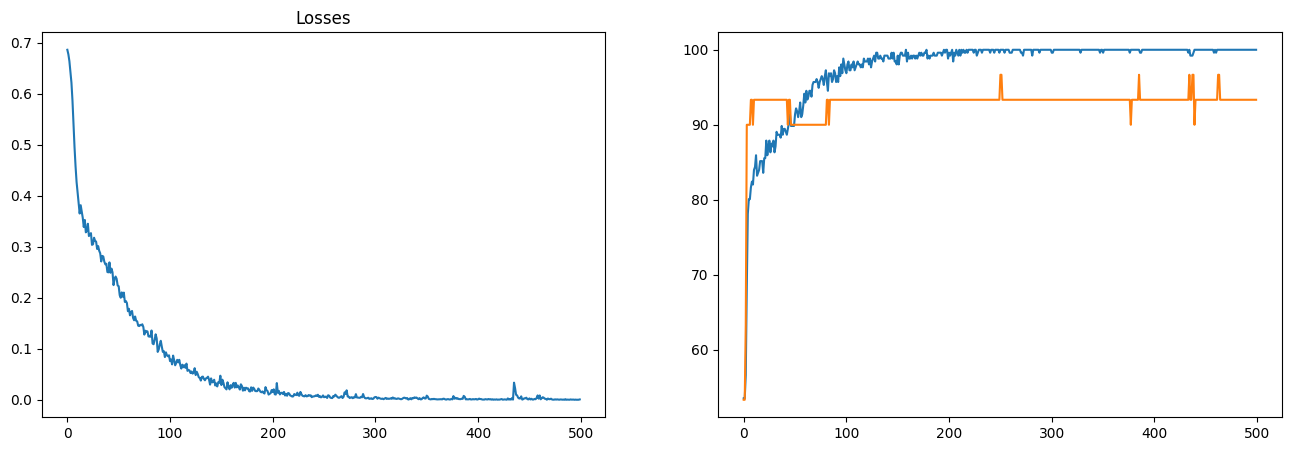

In [244]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_title('Losses')

ax[1].plot(trainAcc)
ax[1].plot(testAcc)

## Weights

In [11]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../sample_data/mnist_train.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [12]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [21]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

for x,y in tmpnet.named_parameters():
    print(x,y.shape)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)
input.weight torch.Size([64, 784])
input.bias torch.Size([64])
fc1.weight torch.Size([32, 64])
fc1.bias torch.Size([32])
fc2.weight torch.Size([32, 32])
fc2.bias torch.Size([32])
output.weight torch.Size([10, 32])
output.bias torch.Size([10])


In [15]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [50]:
results = {}
weights = {}

for num in np.logspace(-4, 1, 25):
    net_zero,lossfun,optimizer = createTheMNISTNet()
    for x,y in net_zero.named_parameters():
        if 'weight' in x:
            with torch.no_grad():
                y.data = torch.Tensor(np.random.normal(0, num, y.shape))

    outputs = np.array([])
    for x,y in net_zero.named_parameters():
        if 'weight' in x:
            with torch.no_grad():
                outputs = np.append(outputs, y.data.flatten().numpy())
    weights[num] = outputs
    
    trainAcc_base,testAcc_base,losses,net_zero = function2trainTheModel(net_zero,lossfun,optimizer)
    results[num] = np.mean(testAcc_base[-3:])

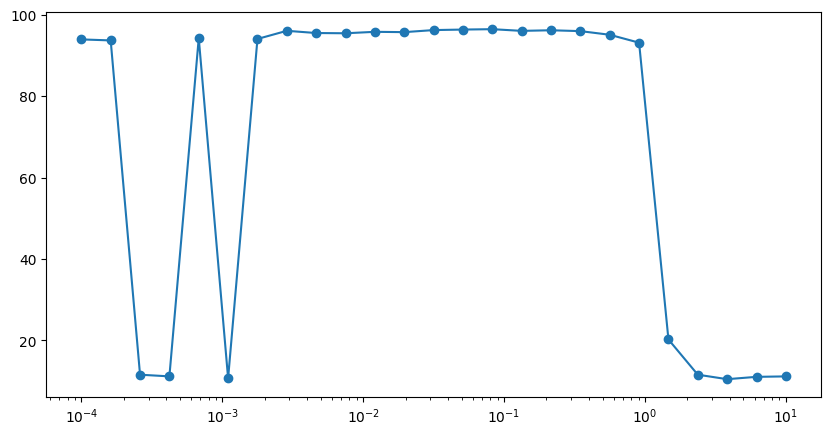

In [51]:
fig = plt.figure(figsize=(10,5))
plt.semilogx(list(results.keys()), list(results.values()),'o-')

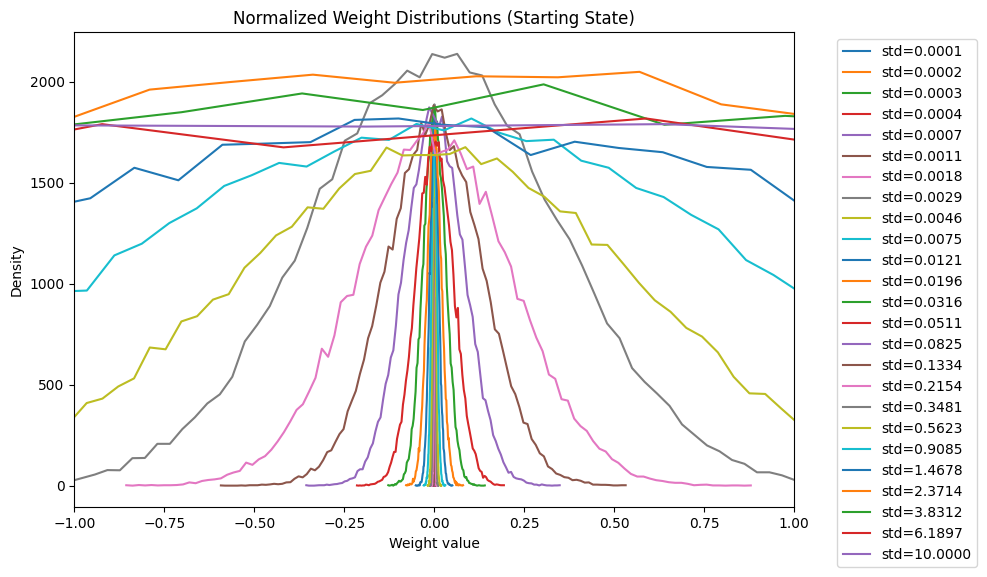

In [67]:
plt.figure(figsize=(10, 6))
# Use a log scale for the x-axis if you want to see the tiny distributions better
for k in weights.keys():
    # Fix: density=True makes all curves comparable
    y, x = np.histogram(weights[k], bins=100, density=False)
    plt.plot((x[1:]+x[:-1])/2, y, label=f'std={k:.4f}')

plt.title('Normalized Weight Distributions (Starting State)')
plt.xlabel('Weight value')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.xlim([-1, 1])
plt.tight_layout()
plt.show()

## Xavier vs Kaiming

In [80]:
data = get_wine_dataset()

In [81]:
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

print(data[cols2zscore].keys())

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)
  
# global parameter
numepochs = 1000

def trainTheModel(winenet, train_loader, test_loader):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


/var/folders/0z/cm5blxwn59lfh8sxl1dd9dgw0000gp/T/ipykernel_62554/3017047514.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/var/folders/0z/cm5blxwn59lfh8sxl1dd9dgw0000gp/T/ipykernel_62554/3017

In [82]:
# test one run first

winenet = ANNwine()

for p in winenet.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal(p[1].data)

trainAcc,testAcc,losses = trainTheModel(winenet, train_loader, test_loader)

/var/folders/0z/cm5blxwn59lfh8sxl1dd9dgw0000gp/T/ipykernel_62554/1257408215.py:7: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(p[1].data)


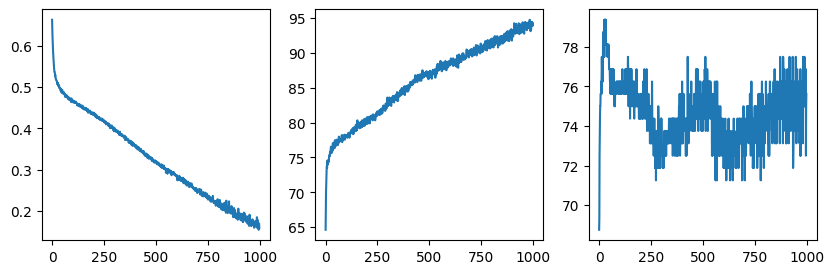

In [101]:
fig,ax = plt.subplots(1,3,figsize=(10, 3))
ax[0].plot(losses)
ax[1].plot(trainAcc)
ax[2].plot(testAcc)
plt.show()

In [109]:
xavier = {
    'losses': [],
    'trainAcc': [],
    'testAcc': []
}

for _ in range(10):
    winenet = ANNwine()

    for p in winenet.named_parameters():
        if 'weight' in p[0]:
            nn.init.xavier_normal(p[1].data)

    trainAcc,testAcc,losses = trainTheModel(winenet, train_loader, test_loader)
    xavier['losses'].append(losses[-1])
    xavier['trainAcc'].append(trainAcc[-1])
    xavier['testAcc'].append(testAcc[-1])

/var/folders/0z/cm5blxwn59lfh8sxl1dd9dgw0000gp/T/ipykernel_62554/2429580669.py:12: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(p[1].data)


In [110]:
kaiming = {
    'losses': [],
    'trainAcc': [],
    'testAcc': []
}

for _ in range(10):
    winenet = ANNwine()

    for p in winenet.named_parameters():
        if 'weight' in p[0]:
            nn.init.kaiming_normal_(p[1].data)

    trainAcc,testAcc,losses = trainTheModel(winenet, train_loader, test_loader)
    kaiming['losses'].append(losses[-1])
    kaiming['trainAcc'].append(trainAcc[-1])
    kaiming['testAcc'].append(testAcc[-1])

Text(0.5, 1.0, 'Final Test Accuracies')

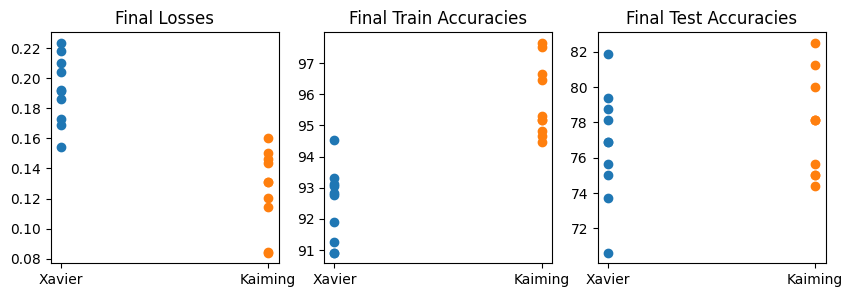

In [111]:
fig,ax = plt.subplots(1,3,figsize=(10, 3))
ax[0].plot(['Xavier']*10, xavier['losses'], 'o')
ax[0].plot(["Kaiming"]*10, kaiming['losses'], 'o')
ax[0].set_title('Final Losses')
ax[1].plot(['Xavier']*10, xavier['trainAcc'], 'o')
ax[1].plot(["Kaiming"]*10, kaiming['trainAcc'], 'o')
ax[1].set_title('Final Train Accuracies')
ax[2].plot(['Xavier']*10, xavier['testAcc'], 'o')
ax[2].plot(["Kaiming"]*10, kaiming['testAcc'], 'o')
ax[2].set_title('Final Test Accuracies')

## Identically Random Weights

In [113]:
net = nn.Sequential(
    nn.Linear(2,8),
    nn.Linear(8,8),
    nn.Linear(8,1))

In [125]:
net_noseed = np.array([])
for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)
    net_noseed = np.append(net_noseed, p[1].data.numpy().flatten())

net_rs1a = np.array([])
torch.manual_seed(10)
for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)
    net_rs1a = np.append(net_rs1a, p[1].data.numpy().flatten())

net_rs1b = np.array([])
torch.manual_seed(10)
for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)
    net_rs1b = np.append(net_rs1b, p[1].data.numpy().flatten())

net_rs2 =  np.array([])
torch.manual_seed(20)
for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)
    net_rs2 = np.append(net_rs2, p[1].data.numpy().flatten())

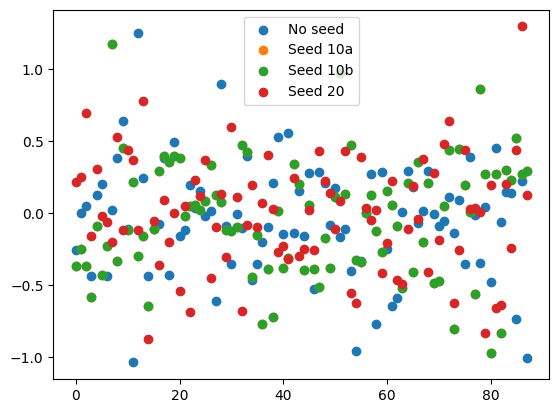

In [129]:
from cProfile import label


plt.scatter(range(len(net_noseed)), net_noseed, label='No seed')
plt.scatter(range(len(net_rs1a)), net_rs1a, label='Seed 10a')
plt.scatter(range(len(net_rs1b)), net_rs1b, label='Seed 10b')
plt.scatter(range(len(net_rs2)), net_rs2, label='Seed 20')

plt.legend()
plt.show()